# Introduction
In this notebook I present my approach to the given Computer Vision Problem. I implemented this problem in Pytorch. 

**Importing Important Libraries**

In [0]:
import pickle # we use pickle to extract the data from the .pkl files given to us
import numpy as np # for processing tensors and numpy arrays
import pandas as pd 
from matplotlib import image # for image processing
import matplotlib.pyplot as plt # for plotting graphs
import torch # for using torch
from torch import nn # for defining layers of the neural network
import torch.nn.functional as F # to apply different activations on the layers
from torchvision import datasets,models,transforms # for creating dataloaders and for data augmentation and normalization
import shutil # for file handling
from PIL import Image # for image processing
from sklearn.model_selection import train_test_split # for creating a training set and a validation set

# Training

**Reading Files Into The memory**

We use python's pickle library to load data from pickle files


*   train_data contains list of training images.
*   train_labels contains the corresponding class each image belongs to.







In [0]:
with open('train_image.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('train_label.pkl', 'rb') as g:
    train_labels = pickle.load(g)
    


**Reshaping the data to view the images**
Since the pixel values of all the images in training, validation and test set are stored as one vector, we will need to reshape the vector to form a image out of it and to be able to run a CNN model.

Since number of pixel for a training set were 784, an obvious guess was to try to reshape it into (28x28), because 28x28=784. We then checked whether the reshaped image make some sense or not by plotting it using matplotlib library of python.

In [0]:
train_data = np.array(data)# converting the data to an array
train_data = np.reshape(image,(8000,28,28)) # reshaping the data so that we can view the images

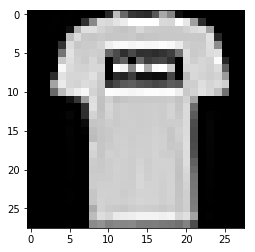

In [0]:
plt.imshow(train_data[0],cmap='gray')# viewing the images in Grayscale

In [0]:
train_data = np.reshape(train_data,(8000,28,28,1)) # Here we again reshape the data(adding a third dimension for number of channels) so that we can insert it into the model

In [0]:
classes = set(train_labels) # to view the unique classes the images belong to.
classes

{0, 2, 3, 6}

**Dividing the data into train and dev(validation) sets using train_test_split.**
The data is divided into 80% training images and 20% validation images

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)

**Organising the images into folders 'train' and 'valid'  each folder containing subfolders corresponding to the labels for the images**  

In [0]:
import os
os.mkdir('train')# making a train directory

for i in classes:
    os.mkdir('train/'+str(i)) # making subfolders for organising images according to their classes

In [0]:
os.mkdir('valid')# making a valid directory

for i in classes:
    os.mkdir('valid/'+str(i))# making subfolders for organising images according to their classes

Each numpy array is converted into an image and is then saved into its respective folder corresponding to its labels.
This is done for both training and validation sets



*   Structure of the data


     train(directory)
        |0(subdirectory)
        |2(subdirectory)
        |3(subdirectory)
        |6(subdirectory)


Each subdirectory contains images with labels same as the subdirectory name

In [0]:
for i in range(X_train.shape[0]):
    img = Image.fromarray(np.array(X_train[i].reshape(28,28)).astype('uint8'))# image converted from numpy array into image
    img.save('train/'+str(y_train[i])+'/'+str(i)+'.jpg')# image is saved into the respective location

for i in range(X_valid.shape[0]):
    img = Image.fromarray(np.array(X_valid[i].reshape(28,28)).astype('uint8'))# image converted from numpy array into image
    img.save('valid/'+str(y_valid[i])+'/'+str(i)+'.jpg')# image is saved into the respective location

**Creating DataLoaders for Training and Validation sets**
Here Data Augmentation has not been used. I tried running the model using data augmentations on the images such as Horizontal flipping , rotation. But the model gave the same results with or without data augmentation therefore data augmentation has not been used as it increases the training time.

**The 1 channel grayscale images have been converted to 3 channels images where each channel is made of the same GrayScale image.**
This approach allows the model to learn more from the same image.

In [0]:
trans = transforms.Compose([transforms.Grayscale(3),transforms.ToTensor()])# to transform the images from 1-channel to 3-channel and convert it into a pytorch tensor
trainset = datasets.ImageFolder('train/',transform=trans)# to load data from the train folder
trainloader = torch.utils.data.DataLoader(trainset,batch_size=100,shuffle=True)

validset = datasets.ImageFolder('valid/',transform=trans)# to load data from the train folder
validloader = torch.utils.data.DataLoader(validset,batch_size=100,shuffle=True)

**Now we define the Train Function which prints the training_loss, validation_loss, validation accuracy and training accuracy calculates forward and back propagation** 



In [0]:
def train(model,trainloader,validloader,opt,criterion,sched,epochs=10):
    model.cuda()# passing the model weights to the gpu
    for e in range(epochs):# looping over each epoch
        train_loss = 0
        train_accuracy = 0
        model.train()# model is toggled to training mode this enables the model's dropout layers.
        for images,labels in trainloader:# loading each batch of the training data
            images = images.cuda()# passing the data to gpu for faster calculations
            labels = labels.cuda()# passing the data to gpu
            log_probs = model(images)# paasing the data through the model
            loss = criterion(log_probs,labels)# calculating the loss. The loss function is categorical CrossEntropyLoss function
            ps = torch.exp(log_probs)# for calculating the accuracy we calculate the probability of each class
            _,top_class = ps.topk(1,dim=1)# then the class with the highest probability is extracted
            equals = top_class == labels.view(top_class.shape)# number of correct predictions is calculated
            train_accuracy += torch.mean(equals.type(torch.FloatTensor))
            opt.zero_grad()
            loss.backward() # Back propagation
            opt.step() # optimizer step
            train_loss += loss.item() 
        else:
            valid_loss = 0
            accuracy = 0
            model.eval()# for disbling the dropouts of the model during inferencing
            with torch.no_grad():# for disabling the calculation of the gradient for validation set
                for images,labels in validloader:# loading each batch of the validation data
                    images = images
                    images = images.cuda()# passing the data to gpu for faster calculations
                    labels = labels.cuda()# passing the data to gpu for faster calculations
                    logps = model(images)# paasing the data through the model
                    valid_loss += criterion(logps,labels)# calculating the validation loss. The loss function is categorical CrossEntropyLoss function
                    ps = torch.exp(logps)# for calculating the accuracy we calculate the probability of each class
                    _,top_class = ps.topk(1,dim=1)# then the class with the highest probability is extracted
                    equals = top_class == labels.view(top_class.shape)# number of correct predictions is calculated
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
            sched.step(valid_loss/len(validloader))
            print('epoch :{}/{} '.format(e+1,epochs),
                'train_loss :{:.3f} '.format(train_loss/len(trainloader)),# printing average training loss
                'test_loss :{:.3f} '.format(valid_loss/len(validloader)),# printing average validation loss
                'test accuracy: {:.3f} '.format(accuracy/len(validloader)),# printing average validation accuracy
                'train accuracy: {:.3f}'.format(train_accuracy/len(trainloader)))# printing average train accuracy
            if e%5 == 0:
                torch.save({'model_state':model.state_dict(),'optimizer_state':optimizer.state_dict()},'models_new_3c_dr0.25_conv_dropout_epoch7_wn')
                #saving model weights after every 5 epochs as check points

**Building The Convolutional Neural Network**

Here I have used convolutional neural network because it will work best on the image data.
It will perform better than Artificial Neural Networks. Transfer Learning from the imagenet dataset has not been used because it does not give good results on the dataset.

In this model convolutional , Batch Normalizations , Max pooling  and Dropout layers have been used . ReLU function has been used as the activation after all layers except the last fully connected layers. Dropout layers help reducing variance of the model. Max Pooling highlight the main features of an image from  previous layers. Batch Normalization helps in speeding up calculations because it reduces the mean to 0 and standard deviation to 1. Then the output from all the convolutional layers is flattened and is passed into the fully connected layers which gives the final probabilities of each class for each input using the softmax activation function 

In [0]:
class my_model(nn.Module):
    def __init__(self,batch_size):
        super().__init__()
        self.bs = batch_size
        self.convol = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.2),
            
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.1),
        
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.1),
        )
        
        self.fc = nn.Sequential(
                                nn.Linear(3200,2048),
                                nn.ReLU(),
                                nn.Dropout(0.2),
            
                                nn.Linear(2048,1024),
                                nn.ReLU(),
                                nn.Dropout(0.1),
            
                                nn.Linear(1024,512),
                                nn.ReLU(),
                                nn.Dropout(0.1),
            
                                nn.Linear(512,256),
                                nn.ReLU(),
            
                                nn.Linear(256,4))
        
        
    def forward(self,x):
        x = self.convol(x)
        x = x.view(self.bs,-1)
        x = self.fc(x)
        x = F.log_softmax(x,dim=1)
        return x

**Before Training the model** 

We use ReduceLROnPlateau for decreasing the learning rate if the validation loss does not decrease for a particular number of epochs

In [0]:
model = my_model(batch_size = 100)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 5)

**Training the model**

Finally we train the model. Each epoch prints the training loss , the validation loss, the validation accuracy and the training accuracy. The loss used is Categorical cross entropy loss which is divided into two parts log_softmax and negative log likelihood loss.

In [0]:
train(model=model,trainloader=trainloader,validloader=validloader,opt=optimizer,criterion=criterion,sched=scheduler,epochs=100)

# Inferencing

**loading the best model**

In [0]:
st_dict = torch.load('models_new_3c_dr0.25_conv_dropout_epoch7_wn',map_location='cpu')# dictionary containing weights

In [0]:
model = my_model(batch_size = 1)# initializing model

In [0]:
model.load_state_dict(st_dict['model_state']) # loading the weights into the model

In [0]:
with open('test_image.pkl', 'rb') as c: # unpickling the test data
    data = pickle.load(c)

In [0]:
len(data)

2000

In [0]:
imgs = np.array(data)# converting the data to numpy array
test_imgs = np.reshape(imgs,(2000,28,28,1))# reshaping the data so that it can be loaded into the model

In [0]:
trans = transforms.Compose([transforms.Grayscale(3),transforms.ToTensor()])# transforming 1-channel images to 3-channel images and converting the images into pytorch tensors

In [0]:
label_mp = {'tensor(0)':0,'tensor(1)':2,'tensor(2)':3,'tensor(3)':6} #mapping labels with the respective classes to which the images belong to

**predicting the labels for the images in the test set**

In [0]:
model.eval()
test_label = []
for i in range(test_imgs.shape[0]):
    img = Image.fromarray(np.array(test_imgs[i].reshape(28,28)).astype('uint8'))# reshaping the image for inputting into the model
    img = trans(img)# transforming the image
    img = torch.unsqueeze(img,dim=0)# adding an extra dimension for number of channels into the images
    log_ps = model(img)
    ps = torch.exp(log_ps)
    _,top_cl = ps.topk(1,dim=1)# taking out the index of the class with the maximum probability
    test_label.append(top_cl[0][0])#appending the labels into a list

In [0]:
orig_labels = [label_mp[str(i)] for i in test_label]# converting the labels to original classes such as '0'->0,'1'->2,'2'->3,'3'->6

**preparing the submission file**

In [0]:
all_rows = []
for i in range(len(orig_labels)):
    l = []
    l.append(i)
    l.append(orig_labels[i])
    all_rows.append(l)

Preds = pd.DataFrame(all_rows,columns=['image_index','class'])
Preds.to_csv('Ritik_Mahajan.csv',index = False)